# Week 2: Quantitative Measures of Population Health — DALYs and QALYs

**Learning Objectives:**
- Understand the components of Disability-Adjusted Life Years (DALYs)
- Calculate Years of Life Lost (YLL) and Years Lived with Disability (YLD)
- Explore how disability weights are determined and their impact on burden estimates
- Compare DALYs and Quality-Adjusted Life Years (QALYs)
- Critically evaluate the assumptions embedded in these measures

---

## 1. Why Do We Need Summary Measures of Health?

Traditional health statistics focus on **mortality** — death rates, life expectancy, cause of death. But this misses something important: **morbidity**.

Consider two conditions:
- **Ischaemic heart disease**: High mortality, significant disability before death
- **Low back pain**: Very low mortality, but affects millions and causes significant suffering

If we only count deaths, we systematically undervalue conditions that cause suffering without killing. Summary measures like DALYs and QALYs attempt to capture **both** mortality and morbidity in a single metric.

### The Policy Question

Imagine you're advising a health ministry with a fixed budget. How do you compare:
- Preventing 100 deaths from heart disease?
- Preventing 10,000 cases of chronic low back pain?
- Curing 500 cases of blindness?

To make these comparisons, we need a **common currency** for health.

## 2. Setup

First, we'll load the utility functions and data for this course.

In [1]:
# ============================================================
# Bootstrap cell (works both locally and in Colab)
#
# What this cell does:
# - Ensures that we are inside the course repository.
# - In Colab: clones the repository from GitHub if necessary.
# - Loads the course utility module (epi_utils.py).
#
# Important:
# - You may see messages printed below (e.g. from pip or git).
# - Warnings (often in yellow) are usually harmless.
# - If you see a red error traceback, re-run this cell first.
# ============================================================

import os
import sys
import pathlib
import subprocess

# ------------------------------------------------------------
# Configuration: repository location and URL
# ------------------------------------------------------------
REPO_URL = "https://github.com/ggkuhnle/fb2nep-epi.git"
REPO_DIR = "fb2nep-epi"

# ------------------------------------------------------------
# 1. Ensure we are inside the repository
# ------------------------------------------------------------
cwd = pathlib.Path.cwd()

# Case A: we are already in the repository (scripts/epi_utils.py exists)
if (cwd / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd
# Case B: we are in a subdirectory of the repository
elif (cwd.parent / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd.parent
# Case C: we are outside the repository (e.g. in Colab)
else:
    repo_root = cwd / REPO_DIR

    # Clone the repository if not present
    if not repo_root.is_dir():
        print(f"Cloning repository from {REPO_URL} into {repo_root} ...")
        subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
    else:
        print(f"Using existing repository at {repo_root}")

    # Change working directory to repository root
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()

# Add scripts directory to Python path
scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

print(f"Repository root: {repo_root}")
print("Bootstrap completed successfully.")

Repository root: /Users/gunter/Documents/fb2nep-epi
Bootstrap completed successfully.


In [30]:
# ------------------------------------------------------------
# Import libraries and course utilities
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# Import course utilities from the repository
from epi_utils import (
    LIFE_TABLE, GBD_DISABILITY_WEIGHTS, EXERCISE_CONDITIONS,
    get_life_expectancy, calculate_yll, calculate_yld, 
    calculate_dalys, calculate_qalys_gained, get_dw
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

print("Libraries loaded successfully.")

Libraries loaded successfully.


## The GBD reference life table (and why we use it for YLL)

When we calculate **Years of Life Lost (YLL)**, we need a benchmark for how many years of life would have been expected *at the age of death*. The Global Burden of Disease (GBD) study uses a **reference life table** for this purpose.

### What the life table contains
The life table provides the **remaining life expectancy** at different ages.

- At age 0, it gives the *expected total length of life at birth* under the reference standard.
- At age 40, it gives the *expected additional years of life remaining* for someone who has reached 40.
- The values decrease with age because fewer years remain.

In this notebook, we use an abridged version of the reference table (a small set of ages) for simplicity.

### How it is used in YLL
For a death at age \(a\), YLL uses:

$$
\text{YLL at age } a = N_a \times L_a
$$

where:
- $N_a$ is the number of deaths at age $a$
- $L_a$ is the **remaining life expectancy** at age $a$ from the reference life table

So if the reference table says the remaining life expectancy at age 50 is 35 years, then each death at age 50 contributes **35 YLL**.

### Why use a reference table rather than country-specific life expectancy?
Using a single reference life table has a clear purpose: it ensures that a death at a given age is valued consistently, regardless of where it occurs.

- If we used country-specific life expectancy, the same death at the same age would generate fewer YLL in countries with lower life expectancy.
- That can be defended descriptively (“that is what is observed locally”), but it embeds a strong normative assumption (“a year of life is worth less in some places”).

GBD’s choice is therefore partly ethical: it reflects an idea of **equal potential longevity**, rather than local averages.

### Important interpretation
The reference life table is **not** a prediction of how long a particular person would have lived.
It is a standard used for accounting, so that YLL is comparable across populations and over time.

We will use this table throughout the notebook whenever we calculate YLL.


In [ ]:
# Plot the GBD reference life table and the implied reference endpoint age
fig, ax = plt.subplots(figsize=(8, 5))

# Remaining life expectancy
ax.plot(
    LIFE_TABLE["age"],
    LIFE_TABLE["life_expectancy"],
    marker="o",
    label="Remaining life expectancy"
)

# Reference endpoint age (age + remaining LE)
ax.plot(
    LIFE_TABLE["age"],
    LIFE_TABLE["age"] + LIFE_TABLE["life_expectancy"],
    marker="s",
    label="Reference endpoint age (age + LE)"
)

ax.set_xlabel("Age (years)")
ax.set_ylabel("Years")
ax.set_title("GBD Reference Life Table and Reference Endpoint Age")

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend()

plt.tight_layout()
plt.show()


## Disability weights (DW): what they mean — and what they do not

A **disability weight (DW)** quantifies how far a given health state falls short of full health.

- DW = 0 means full health  
- DW = 1 means a health state equivalent to death  

Disability weights are therefore **not probabilities**, **not risks**, and **not measures of severity in a clinical sense**. They are scaling factors used to convert time lived in a health state into **healthy-equivalent years lost**.

### How DW enters the YLD calculation
In the prevalence-based formulation used here:

$$
\text{YLD} = \text{Prevalence} \times \text{DW}
$$

If 10,000 people live for one year with a condition that has DW = 0.20, this corresponds to:

- 10,000 years lived in that state, but
- 2,000 **healthy-equivalent years lost** in that year.

The remaining 8,000 years are interpreted as healthy-equivalent years lived.

### What disability weights represent
A disability weight answers the question:

> *“How much healthy life is lost while living in this health state, relative to full health?”*

It does **not** answer:
- how frightening the condition is,
- how unacceptable it feels morally,
- how likely it is to lead to death,
- how much society should care about it.

Those considerations enter policy decisions elsewhere — not in the DW itself.

### Disability weights and death
Disability weights apply **only to time spent alive**.

- Losses due to **premature death** are captured separately through **Years of Life Lost (YLL)**.
- As a result, highly lethal diseases with short symptomatic phases (e.g. Ebola, rabies) often have **moderate disability weights**, but very large YLL.
- Chronic, non-fatal conditions can generate large YLD despite low or zero mortality.

This separation is intentional and central to the DALY framework.

### Why disability weights are bounded between 0 and 1
In DALYs, disability weights are restricted to the interval [0, 1].

- Some valuation systems used in QALYs allow states to be valued as *worse than death* (negative utilities).
- The GBD framework does **not** allow negative values; a state equivalent to death has DW = 1, and no state exceeds this.

This design choice avoids certain ethical and interpretive problems, but it also imposes limits on what the DW scale can express.

In the next section, we examine **how disability weights are elicited**, and why different methods (VAS, TTO, standard gamble) often produce systematically different values.


In [ ]:
# View disability weights for selected conditions
print("GBD 2019 Disability Weights (selected conditions)")
print("=" * 60)
display(GBD_DISABILITY_WEIGHTS.sort_values(by=["disability_weight", "category"],
        ascending=[False, True]))


## 3. Building DALYs from First Principles

The DALY combines two components:

$$\text{DALY} = \text{YLL} + \text{YLD}$$

Where:
- **YLL** (Years of Life Lost) = years lost due to premature mortality
- **YLD** (Years Lived with Disability) = years lived in less than perfect health

**Key insight**: 1 DALY = 1 year of healthy life lost. Higher DALYs = greater burden.

### 3.1 Years of Life Lost (YLL)

YLL measures premature mortality by comparing actual age at death to a reference life expectancy:

$$\text{YLL} = N \times L$$

Where:
- $N$ = number of deaths
- $L$ = standard life expectancy at age of death

In [ ]:
# Example: Mortality from ischaemic heart disease
ihd_deaths = {
    45: 50,
    55: 200,
    65: 500,
    75: 800,
    85: 400
}

total_yll, yll_breakdown = calculate_yll(ihd_deaths)

print(f"Ischaemic Heart Disease - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(ihd_deaths.values()):,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll/sum(ihd_deaths.values()):.1f} years")

### Exercise 3.1: Calculate YLL for a different condition

Road traffic accidents tend to affect younger people. Calculate the YLL using the mortality data below and compare to IHD.

In [ ]:
# Road traffic accident deaths
rta_deaths = {
    15: 50,
    25: 80,
    35: 60,
    45: 40,
    55: 20,
    65: 10
}

total_rta_yll, yll_rta_breakdown = calculate_yll(rta_deaths)

print(f"Road traffic accidents - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(rta_deaths.values()):,}")
print(f"Total YLL: {total_rta_yll:,.0f} years")
print(f"Average YLL per death: {total_rta_yll/sum(rta_deaths.values()):.1f} years")




Now, compare with IHD: 

In [ ]:
print(f"Ischaemic Heart Disease - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(ihd_deaths.values()):,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll/sum(ihd_deaths.values()):.1f} years")

### 3.2 Years Lived with Disability (YLD)

YLD captures the morbidity burden:

$$\text{YLD} = P \times DW$$

Where:
- $P$ = prevalence (number of cases) × average duration
- $DW$ = disability weight (0 to 1)

In [ ]:
# Example: Comparing YLD for different conditions
conditions = [
    {'name': 'Type 2 diabetes (without complications)', 'prevalence': 100000}, 
    {'name': 'Depression (moderate)', 'prevalence': 20000}, 
    {'name': 'Back pain (severe)', 'prevalence': 15000},
    {'name': 'Blindness', 'prevalence': 5000, 'dw': 0.187}
]

print("YLD Comparison (prevalence-based, 1 year)")
print("=" * 70)

yld_results = []
for c in conditions:
    dw = get_dw(c["name"])
    yld = calculate_yld(c["prevalence"], dw)

    yld_results.append({
        "Condition": c["name"],
        "Prevalence": f"{c['prevalence']:,}",
        "Disability weight (DW)": round(dw, 3),
        "YLD": int(round(yld, 0)),
    })

display(pd.DataFrame(yld_results))

### 3.3 Putting it Together: Total DALYs

We now combine **Years of Life Lost (YLL)** and **Years Lived with Disability (YLD)** into a single summary measure:

$$
\text{DALYs} = \text{YLL} + \text{YLD}
$$

This simple identity hides an important conceptual point: **DALYs are additive across very different kinds of health loss**.

- **YLL** captures the loss due to premature death, using a reference life expectancy.
- **YLD** captures the loss due to living in less than full health, scaled by disability weights.

Both components are expressed in the same unit: **healthy years of life lost**.

### Interpreting DALYs
A condition can generate a high DALY burden in very different ways:

- High **YLL**, low **YLD**  
  → diseases that kill many people or kill at younger ages (e.g. cardiovascular disease, injuries)

- Low **YLL**, high **YLD**  
  → chronic, non-fatal conditions affecting many people (e.g. depression, low back pain)

- High **YLL** and **YLD**  
  → conditions that both shorten life and cause prolonged disability

DALYs make these patterns directly comparable.

### What DALYs are — and are not
DALYs are designed for **population-level comparison and prioritisation**.

They are:
- additive across diseases, ages, and populations
- comparable across settings (because they use a reference life table and common disability weights)

They are **not**:
- measures of individual suffering
- predictions of what would happen to a specific person
- moral judgements about whose lives matter more

In the next sections, we will use DALYs to compare conditions with very different profiles and explore how assumptions (especially disability weights) influence rankings.


In [3]:
# Ischaemic Heart Disease: high mortality, moderate disability

ihd_condition = "Ischaemic Heart Disease"

ihd = calculate_dalys(
    deaths_by_age={45: 50, 55: 200, 65: 500, 75: 800, 85: 400},
    prevalence=50000,
    disability_weight=get_dw(ihd_condition),
    condition_name=ihd_condition
)


Ischaemic Heart Disease - DALY Calculation
YLL (Years of Life Lost):                40,295
YLD (Years Lived with Disability):        3,600
--------------------------------------------------
Total DALYs:                             43,895

YLL proportion: 91.8%
YLD proportion: 8.2%


In [4]:
# Low Back Pain: very low mortality, high disability burden

lbp_condition = "Back pain (severe)"

lbp = calculate_dalys(
    deaths_by_age={75: 5, 85: 10},
    prevalence=200000,
    disability_weight=get_dw(lbp_condition),
    condition_name=lbp_condition
)


Back pain (severe) - DALY Calculation
YLL (Years of Life Lost):                   190
YLD (Years Lived with Disability):       65,000
--------------------------------------------------
Total DALYs:                             65,190

YLL proportion: 0.3%
YLD proportion: 99.7%


## Let's compare

In [14]:
# Simulated individuals (illustrative)
people = [
    {
        "id": "Person A",
        "age_at_death": 75,
        "years_with_condition": 40,
        "condition": "Depression (moderate)",
    },
    {
        "id": "Person B",
        "age_at_death": 65,
        "years_with_condition": 2,
        "condition": "Cancer (terminal, with severe pain)",
    },
    {
        "id": "Person C",
        "age_at_death": 60,
        "years_with_condition": 35,
        "condition": "Obesity (class III, BMI >= 40)",
    },
    {
        "id": "Person D",
        "age_at_death": 85,
        "years_with_condition": 75,
        "condition": "Iron deficiency",
    },
]



results = []

for p in people:
    # Get disability weight
    dw = get_dw(p["condition"])

    # YLL: remaining life expectancy at age of death
    yll = get_life_expectancy(p["age_at_death"])

    # YLD: years lived with disability × DW
    yld = p["years_with_condition"] * dw

    # DALYs = YLL + YLD
    daly = yll + yld

    results.append({
        "Person": p["id"],
        "Condition": p["condition"],
        "Years lived with condition": p["years_with_condition"],
        "Age at death": p["age_at_death"],
        "DW": round(dw, 3),
        "YLL": yll,
        "YLD": yld,
        "DALYs": daly,
    })

df_individual = pd.DataFrame(results)
display(df_individual.round(2))


,Person,Condition,Years lived with condition,Age at death,DW,YLL,YLD,DALYs
0,Person A,Depression (moderate),40,75,0.40,17.5,15.84,33.34
1,Person B,"Cancer (terminal, with severe pain)",2,65,0.57,25.9,1.14,27.04
2,Person C,"Obesity (class III, BMI >= 40)",35,60,0.09,30.4,3.01,33.41
3,Person D,Iron deficiency,75,85,0.00,10.3,0.30,10.60


> In this simplified individual-level illustration, DALYs represent the total number of healthy years lost over a person’s lifetime, combining time lived in less-than-full health (YLD) and years of life lost due to premature death (YLL).

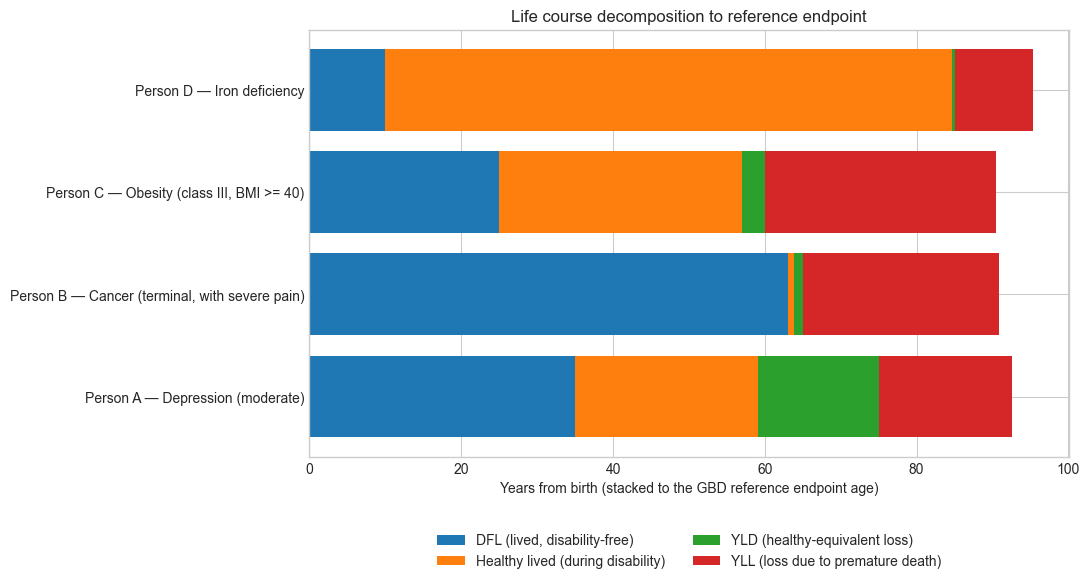

In [26]:

rows = []
for p in people:
    age = p["age_at_death"]
    t = p["years_with_condition"]
    dw = get_dw(p["condition"])

    # Simple assumption for teaching: condition starts t years before death
    dfl_years = max(age - t, 0)                 # years lived disability-free
    lived_with_disability_healthy = t * (1 - dw)
    yld = t * dw

    # YLL from the reference life table (remaining LE at age of death)
    yll = get_life_expectancy(age)

    reference_endpoint = age + yll

    rows.append({
        "Age at death": p["age_at_death"],
        "Person": p["id"],
        "Condition": p["condition"],
        "DFL (years lived disability-free)": dfl_years,
        "Healthy lived (during disability)": lived_with_disability_healthy,
        "YLD (healthy years lost)": yld,
        "YLL (years of life lost)": yll,
        "Reference endpoint age": reference_endpoint,
    })

df = pd.DataFrame(rows)

# ---- Plot (horizontal stacked bars read better) ----

fig, ax = plt.subplots(figsize=(11, 6))

y = np.arange(len(df))
left = np.zeros(len(df))

ax.barh(y, df["DFL (years lived disability-free)"], left=left, label="DFL (lived, disability-free)")
left += df["DFL (years lived disability-free)"]

ax.barh(y, df["Healthy lived (during disability)"], left=left, label="Healthy lived (during disability)")
left += df["Healthy lived (during disability)"]

ax.barh(y, df["YLD (healthy years lost)"], left=left, label="YLD (healthy-equivalent loss)")
left += df["YLD (healthy years lost)"]

ax.barh(y, df["YLL (years of life lost)"], left=left, label="YLL (loss due to premature death)")

# ---- Y-axis labels: Person + condition ----
y_labels = df["Person"] + " — " + df["Condition"]
ax.set_yticks(y)
ax.set_yticklabels(y_labels)

ax.set_xlabel("Years from birth (stacked to the GBD reference endpoint age)")
ax.set_title("Life course decomposition to reference endpoint")

# ---- Legend underneath ----
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()



In [27]:
display(
    df[[
        "Person",
        "Condition",
        "Age at death",
        "Reference endpoint age",
        "DFL (years lived disability-free)",
        "Healthy lived (during disability)",
        "YLD (healthy years lost)",
        "YLL (years of life lost)",
    ]].round(2)
)

,Person,Condition,Age at death,Reference endpoint age,DFL (years lived disability-free),Healthy lived (during disability),YLD (healthy years lost),YLL (years of life lost)
0,Person A,Depression (moderate),75,92.5,35,24.16,15.84,17.5
1,Person B,"Cancer (terminal, with severe pain)",65,90.9,63,0.86,1.14,25.9
2,Person C,"Obesity (class III, BMI >= 40)",60,90.4,25,31.99,3.01,30.4
3,Person D,Iron deficiency,85,95.3,10,74.70,0.30,10.3


In [42]:
# ------------------------------------------------------------
# Interactive life-course decomposition for 2 simulated people
# - Random initial conditions
# - Randomise button
# - No "Order" widget
# - Enforce Years <= Age at the widget level
# ------------------------------------------------------------


# Build list of selectable condition names
condition_options = sorted(GBD_DISABILITY_WEIGHTS["condition"].dropna().unique().tolist())
if len(condition_options) < 2:
    raise ValueError("Need at least two conditions in GBD_DISABILITY_WEIGHTS.")

# RNG for reproducible randomisation within the session
_rng = np.random.default_rng()

def _pick_two_distinct_conditions():
    return _rng.choice(condition_options, size=2, replace=False)

c_init_1, c_init_2 = _pick_two_distinct_conditions()

# --- Widgets ---
cond1 = widgets.Dropdown(options=condition_options, value=c_init_1, description="Cond 1:")
cond2 = widgets.Dropdown(options=condition_options, value=c_init_2, description="Cond 2:")

age1 = widgets.IntSlider(value=75, min=0, max=100, step=1, description="Age 1:")
age2 = widgets.IntSlider(value=65, min=0, max=100, step=1, description="Age 2:")

# Years sliders: max will be kept in sync with corresponding age slider
t1 = widgets.IntSlider(value=10, min=0, max=age1.value, step=1, description="Years 1:")
t2 = widgets.IntSlider(value=5,  min=0, max=age2.value, step=1, description="Years 2:")

randomise_btn = widgets.Button(description="Randomise conditions", button_style="info")

out = widgets.Output()

def _sync_years_with_age(age_slider, years_slider):
    """
    Ensure the years slider cannot exceed age.
    - Sets years_slider.max = age
    - If current years > age, reduces it to age
    """
    new_max = age_slider.value
    years_slider.max = new_max
    if years_slider.value > new_max:
        years_slider.value = new_max

def _build_df(conds, ages, years):
    rows = []
    for i, (cond, age, t) in enumerate(zip(conds, ages, years), start=1):
        # Defensive clamp (should already hold because of widget syncing)
        t_eff = min(t, age)

        dw = get_dw(cond)
        yll = get_life_expectancy(age)

        dfl = age - t_eff
        healthy_lived_during_disability = t_eff * (1 - dw)
        yld = t_eff * dw

        rows.append({
            "Person": f"Person {i}",
            "Condition": cond,
            "Age at death": age,
            "Years with condition": t_eff,
            "DW": dw,
            "DFL (years lived disability-free)": dfl,
            "Healthy lived (during disability)": healthy_lived_during_disability,
            "YLD (healthy years lost)": yld,
            "YLL (years of life lost)": yll,
            "DALYs (YLD + YLL)": yld + yll,
            "Reference endpoint age": age + yll,
        })

    return pd.DataFrame(rows)

def _plot_df(df):
    fig, ax = plt.subplots(figsize=(12, 5))

    y = np.arange(len(df))
    left = np.zeros(len(df))

    ax.barh(y, df["DFL (years lived disability-free)"], left=left, label="DFL (lived, disability-free)")
    left += df["DFL (years lived disability-free)"]

    ax.barh(y, df["Healthy lived (during disability)"], left=left, label="Healthy lived (during disability)")
    left += df["Healthy lived (during disability)"]

    ax.barh(y, df["YLD (healthy years lost)"], left=left, label="YLD (healthy-equivalent loss)")
    left += df["YLD (healthy years lost)"]

    ax.barh(y, df["YLL (years of life lost)"], left=left, label="YLL (loss due to premature death)")
    left += df["YLL (years of life lost)"]

    # Labels: Person — Condition
    y_labels = df["Person"] + " — " + df["Condition"]
    ax.set_yticks(y)
    ax.set_yticklabels(y_labels)

    ax.set_xlabel("Years from birth (stacked to the GBD reference endpoint age)")
    ax.set_title("Interactive life-course decomposition: DFL → disability → YLD → YLL")

    # Legend underneath
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=2,
        frameon=False
    )

    plt.tight_layout()
    plt.show()

def update(*_):
    with out:
        clear_output(wait=True)

        df = _build_df(
            conds=[cond1.value, cond2.value],
            ages=[age1.value, age2.value],
            years=[t1.value, t2.value],
        )

        _plot_df(df)

        display(
            df[[
                "Person",
                "Condition",
                "Age at death",
                "Years with condition",
                "DW",
                "YLD (healthy years lost)",
                "YLL (years of life lost)",
                "DALYs (YLD + YLL)",
                "Reference endpoint age",
            ]].round({
                "DW": 3,
                "YLD (healthy years lost)": 2,
                "YLL (years of life lost)": 2,
                "DALYs (YLD + YLL)": 2,
                "Reference endpoint age": 1,
            })
        )

# --- Age -> Years syncing ---
def on_age1_change(change):
    _sync_years_with_age(age1, t1)
    update()

def on_age2_change(change):
    _sync_years_with_age(age2, t2)
    update()

age1.observe(on_age1_change, names="value")
age2.observe(on_age2_change, names="value")

# Other widgets can just trigger update
for w in [cond1, cond2, t1, t2]:
    w.observe(update, names="value")

# Randomise button handler
def on_randomise_clicked(_):
    c1, c2 = _pick_two_distinct_conditions()
    # Setting values will trigger update via observers
    cond1.value = c1
    cond2.value = c2

randomise_btn.on_click(on_randomise_clicked)

# Initial sync (important if defaults changed)
_sync_years_with_age(age1, t1)
_sync_years_with_age(age2, t2)

controls = widgets.VBox([
    widgets.HTML("<b>Choose 2 conditions and life histories</b>"),
    widgets.HBox([cond1, age1, t1]),
    widgets.HBox([cond2, age2, t2]),
    randomise_btn
])

display(controls, out)
update()


Output()

## 4. The Disability Weight Exercise

### 4.1 How GBD Determines Disability Weights

The Global Burden of Disease study uses **paired comparisons** from population surveys. Respondents are presented with two hypothetical health states and asked which they consider healthier.

### 4.2 Other elicitation methods (and why they differ)

Different elicitation methods often produce systematically different values for the same health state.

- **Visual analogue scale (VAS):** respondents place a health state on a line (for example 0 = death, 100 = full health). This is simple, but it is sensitive to anchoring and does not enforce an explicit trade-off.
- **Time trade-off (TTO):** respondents trade length of life for quality of life (for example, 10 years in a health state is equivalent to *x* years in full health). This enforces a quantity–quality trade, but results depend on the time horizon and attitudes to death.
- **Standard gamble (SG):** respondents choose between a certain impaired health state and a gamble between full health and immediate death. This incorporates risk and is influenced by risk aversion.
- **Person trade-off (PTO):** respondents trade benefits across people (for example, curing 100 people of A versus curing *y* people of B). This resembles policy choices but mixes severity with moral judgements about distribution.

**Utilities and negative values:** in some QALY valuation systems, a health state can be valued as worse than death, producing negative utilities. Disability weights used in DALYs are bounded between 0 and 1; they do not take negative values.



### 4.3 Mini-exercise: VAS versus TTO for one health state

In this mini-exercise you will value one health state using two methods:

- VAS: you place the state on a 0–100 scale
- TTO: you indicate how many years in full health are equivalent to 10 years in the state

We convert to a disability weight using:
$$DW = 1 - u$$
where $u$ is the implied utility.

In [ ]:
# Choose one condition for the method comparison
condition_name = "Moderate major depressive disorder"
gbd_dw = get_dw(condition_name)
gbd_u = 1 - gbd_dw

print(f"Condition: {condition_name}")
print(f"GBD disability weight (DW): {gbd_dw:.3f}  |  implied utility (1-DW): {gbd_u:.3f}")

In [ ]:
# Interactive comparison: VAS and TTO

vas = widgets.IntSlider(
    value=70, min=0, max=100, step=1,
    description="VAS (0–100):",
    continuous_update=False
)

tto = widgets.FloatSlider(
    value=8.0, min=0.0, max=10.0, step=0.1,
    description="TTO (years):",
    continuous_update=False
)

out = Output()

def update_display(change=None):
    with out:
        out.clear_output(wait=True)

        # VAS utility and DW
        u_vas = vas.value / 100
        dw_vas = 1 - u_vas

        # TTO utility and DW (10-year horizon)
        u_tto = tto.value / 10
        dw_tto = 1 - u_tto

        df = pd.DataFrame(
            {
                "Method": ["VAS", "TTO (10-year horizon)", "GBD (reference)"],
                "Utility (u)": [u_vas, u_tto, 1 - gbd_dw],
                "Disability weight (DW = 1-u)": [dw_vas, dw_tto, gbd_dw],
            }
        )

        display(df.style.format({"Utility (u)": "{:.3f}", "Disability weight (DW = 1-u)": "{:.3f}"}))

for w in [vas, tto]:
    w.observe(update_display, names="value")

update_display()
display(VBox([widgets.HTML("<b>Set values and compare:</b>"), vas, tto, out]))

In [ ]:
# Display conditions for students to consider
print("DISABILITY WEIGHT EXERCISE")
print("=" * 80)
print("\nAssign a disability weight (0-1) to each condition below.")
print("0 = perfect health, 1 = equivalent to death")
print("-" * 80)

for i, c in enumerate(EXERCISE_CONDITIONS, 1):
    print(f"\n{i}. {c['name'].upper()}")
    print(f"   {c['description']}")

In [ ]:
# Interactive widget for setting disability weights
sliders = {}
slider_widgets = []

for c in EXERCISE_CONDITIONS:
    slider = FloatSlider(
        value=0.1, min=0, max=1, step=0.01,
        description='',
        continuous_update=False,
        readout_format='.2f',
        layout=widgets.Layout(width='300px')
    )
    sliders[c['name']] = slider
    label = widgets.HTML(value=f"<b>{c['name']}</b>", layout=widgets.Layout(width='200px'))
    slider_widgets.append(HBox([label, slider]))

output = Output()

def compare_weights(change=None):
    with output:
        output.clear_output(wait=True)
        
        comparison_data = []
        for c in EXERCISE_CONDITIONS:
            your_weight = sliders[c['name']].value
            gbd_weight = c['gbd_weight']
            comparison_data.append({
                'Condition': c['name'],
                'Your Weight': your_weight,
                'GBD Weight': gbd_weight,
                'Difference': your_weight - gbd_weight
            })
        
        df = pd.DataFrame(comparison_data)
        
        # Create comparison plot
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df))
        width = 0.35
        
        ax.bar(x - width/2, df['Your Weight'], width, label='Your weights', color='steelblue')
        ax.bar(x + width/2, df['GBD Weight'], width, label='GBD weights', color='coral')
        
        ax.set_ylabel('Disability Weight')
        ax.set_title('Your Disability Weights vs GBD 2019')
        ax.set_xticks(x)
        ax.set_xticklabels(df['Condition'], rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0, 1)
        plt.tight_layout()
        plt.show()
        
        print("\nComparison Table:")
        display(df.style.format({
            'Your Weight': '{:.3f}',
            'GBD Weight': '{:.3f}',
            'Difference': '{:+.3f}'
        }).background_gradient(subset=['Difference'], cmap='RdYlGn_r', vmin=-0.3, vmax=0.3))

for slider in sliders.values():
    slider.observe(compare_weights, names='value')

compare_button = widgets.Button(description="Compare to GBD", button_style='primary')
compare_button.on_click(compare_weights)

print("Adjust the sliders to set your disability weights, then click 'Compare to GBD':")
display(VBox(slider_widgets + [compare_button, output]))

### 4.3 Your Turn: Set Your Own Disability Weights

Assign your own disability weights to a set of conditions, then compare to GBD values.

In [ ]:
# Display conditions for students to consider
print("DISABILITY WEIGHT EXERCISE")
print("=" * 80)
print("\nAssign a disability weight (0–1) to each condition below.")
print("0 = full health, 1 = equivalent to death")
print("-" * 80)

for i, c in enumerate(EXERCISE_CONDITIONS, 1):
    print(f"\n{i}. {c['name'].upper()}")
    print(f"   {c['description']}")

In [ ]:
# Interactive widget for setting disability weights

sliders = {}
slider_widgets = []

for c in EXERCISE_CONDITIONS:
    slider = FloatSlider(
        value=0.10, min=0.0, max=1.0, step=0.01,
        description="",
        continuous_update=False,
        readout_format=".2f",
        layout=widgets.Layout(width="320px")
    )
    sliders[c["name"]] = slider
    label = widgets.HTML(value=f"<b>{c['name']}</b>", layout=widgets.Layout(width="220px"))
    slider_widgets.append(HBox([label, slider]))

output = Output()

def compare_weights(change=None):
    with output:
        output.clear_output(wait=True)

        comparison_data = []
        for c in EXERCISE_CONDITIONS:
            your_weight = sliders[c["name"]].value
            gbd_weight = c["gbd_weight"]
            comparison_data.append(
                {
                    "Condition": c["name"],
                    "Your weight": your_weight,
                    "GBD weight": gbd_weight,
                    "Difference (you - GBD)": your_weight - gbd_weight,
                }
            )

        df = pd.DataFrame(comparison_data)

        # Simple plot without hard-coded colours
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df))
        width = 0.40

        ax.bar(x - width/2, df["Your weight"], width, label="Your weights")
        ax.bar(x + width/2, df["GBD weight"], width, label="GBD weights")

        ax.set_ylabel("Disability weight")
        ax.set_title("Your disability weights versus GBD 2019")
        ax.set_xticks(x)
        ax.set_xticklabels(df["Condition"], rotation=45, ha="right")
        ax.set_ylim(0, 1)
        ax.legend()
        plt.tight_layout()
        plt.show()

        display(
            df.style.format(
                {"Your weight": "{:.3f}", "GBD weight": "{:.3f}", "Difference (you - GBD)": "{:+.3f}"}
            )
        )

for slider in sliders.values():
    slider.observe(compare_weights, names="value")

compare_button = widgets.Button(description="Compare to GBD")
compare_button.on_click(compare_weights)

print("Adjust the sliders, then click 'Compare to GBD':")
display(VBox(slider_widgets + [compare_button, output]))

### 4.5 Discussion Questions

1. **Where did you differ most from GBD?** Why might your valuation differ?

2. **Adaptation**: People living with a condition often rate it less severe. Whose values should count?

3. **Cultural variation**: Might conditions be valued differently across cultures?

4. **The "worse than death" problem**: GBD caps weights at 1.0. How should we handle states some consider worse than death?

## 5. How Disability Weights Change Rankings

Let's see how your disability weights would change burden rankings.

In [ ]:
# Hypothetical prevalence data
population_data = {
    'Mild anaemia': {'prevalence': 500000, 'deaths_by_age': {}},
    'Moderate hearing loss': {'prevalence': 300000, 'deaths_by_age': {}},
    'Moderate depression': {'prevalence': 150000, 'deaths_by_age': {45: 50, 55: 30, 65: 20}},
    'Severe low back pain': {'prevalence': 100000, 'deaths_by_age': {}},
    'Complete blindness': {'prevalence': 30000, 'deaths_by_age': {}},
    'Severe dementia': {'prevalence': 80000, 'deaths_by_age': {75: 2000, 85: 5000}},
    'Type 2 diabetes (controlled)': {'prevalence': 400000, 'deaths_by_age': {55: 100, 65: 500, 75: 1000, 85: 500}},
    'Obesity (BMI ≥ 40)': {'prevalence': 200000, 'deaths_by_age': {45: 50, 55: 200, 65: 300, 75: 200}}
}

def calculate_burden_rankings(population_data, disability_weights):
    results = []
    for condition, data in population_data.items():
        dw = disability_weights.get(condition, 0.1)
        yll = 0
        if data['deaths_by_age']:
            yll, _ = calculate_yll(data['deaths_by_age'])
        yld = calculate_yld(data['prevalence'], dw)
        dalys = yll + yld
        results.append({'Condition': condition, 'DW': dw, 'YLL': yll, 'YLD': yld, 'DALYs': dalys})
    
    df = pd.DataFrame(results).sort_values('DALYs', ascending=False)
    df['Rank'] = range(1, len(df) + 1)
    return df[['Rank', 'Condition', 'DW', 'YLL', 'YLD', 'DALYs']]

In [ ]:
# Calculate rankings with GBD weights
gbd_weights = {c['name']: c['gbd_weight'] for c in EXERCISE_CONDITIONS}
gbd_rankings = calculate_burden_rankings(population_data, gbd_weights)

print("Disease Burden Rankings using GBD Disability Weights")
print("=" * 80)
display(gbd_rankings.style.format({'DW': '{:.3f}', 'YLL': '{:,.0f}', 'YLD': '{:,.0f}', 'DALYs': '{:,.0f}'}))

In [ ]:
# Calculate rankings with YOUR weights
your_weights = {name: slider.value for name, slider in sliders.items()}
your_rankings = calculate_burden_rankings(population_data, your_weights)

print("Disease Burden Rankings using YOUR Disability Weights")
print("=" * 80)
display(your_rankings.style.format({'DW': '{:.3f}', 'YLL': '{:,.0f}', 'YLD': '{:,.0f}', 'DALYs': '{:,.0f}'}))

## 6. DALYs vs QALYs

| Aspect | DALY | QALY |
|--------|------|------|
| **Direction** | Higher = more burden | Higher = more health |
| **Primary use** | Population burden estimation | Cost-effectiveness analysis |
| **Key user** | GBD, WHO | NICE, health economists |

In [ ]:
# Example: Cataract surgery
qalys, utility_gain = calculate_qalys_gained(
    intervention_effect=0.95,
    population=10000,
    duration=15,
    dw_before=0.187,
    dw_after=0.003
)

print("Cataract Surgery Programme")
print("=" * 50)
print(f"Population: 10,000 people with cataracts")
print(f"Success rate: 95%")
print(f"Duration of benefit: 15 years")
print(f"\nUtility gain per person: {utility_gain:.3f}")
print(f"Total QALYs gained: {qalys:,.0f}")
print(f"\nIf programme costs £10M: £{10000000/qalys:,.0f} per QALY")
print(f"NICE threshold: £20,000-£30,000 per QALY")

## 7. Limitations and Critique

### The Disability Rights Critique

Some argue that QALYs/DALYs discriminate against disabled people.

In [ ]:
# Illustration: The discrimination problem
print("The QALY Discrimination Problem")
print("=" * 60)
print("\nScenario: A life-saving treatment adding 10 years of life.\n")

qalys_nondisabled = 10 * (1 - 0)
print(f"Patient A (no disability): 10 years × 1.0 = {qalys_nondisabled:.1f} QALYs\n")

qalys_disabled = 10 * (1 - 0.133)
print(f"Patient B (paraplegia, DW=0.133): 10 years × 0.867 = {qalys_disabled:.1f} QALYs\n")

print("-" * 60)
print(f"Patient A's life is valued {qalys_nondisabled/qalys_disabled:.1%} as much as Patient B's.")
print(f"\nIs this fair?")

## 8. Exercises

### Exercise 1: Calculate DALYs for Iron Deficiency Anaemia

Data (hypothetical UK population):
- Mild anaemia: 800,000 (DW=0.004)
- Moderate anaemia: 150,000 (DW=0.052)
- Severe anaemia: 20,000 (DW=0.149)
- Deaths: 500 at age 75, 1000 at age 85

In [ ]:
# YOUR CODE HERE



### Exercise 2: Reflection Questions

1. The GBD weight for obesity (0.086) is lower than for depression (0.145). Do you agree?

2. Should DALYs include age-weighting (valuing years in middle-age more)? Why did GBD remove this?

3. How might you measure the burden of poor diet without relying on disease categories?

---

## References

- GBD 2019 Diseases and Injuries Collaborators. (2020). *The Lancet*.
- Salomon JA et al. (2015). Disability weights for GBD 2013. *Lancet Global Health*.
- Nord E. (2015). Limitations of the QALY. *Cambridge Quarterly of Healthcare Ethics*.